# Premier League Analytics
## by Mathias Brønd Sørensen

## Preliminary Wrangling

The dataset is describing football matches, players and teams from Europe and is obtained from [Kaggle](https://www.kaggle.com/hugomathien/soccer).

The data is organized in a third normalized relational database, why the first task will be to wrangle the data into a 'tidy' dataset.

As my own personal favorite is the English Premier League, the analysis will focus on this and hopefully we'll find some insights that will also suprise me!

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import sqlalchemy as sql
import re as re

%matplotlib inline

In [2]:
# Create a sql engine
engine = sql.create_engine('sqlite:///database.sqlite')

In [3]:
# Connect to the engine
connection = engine.connect()

In [4]:
# Inspect the tables in the database
inspector = sql.inspect(engine)
for table_name in inspector.get_table_names():
    print("Table: %s" % table_name)

Table: Country
Table: League
Table: Match
Table: Player
Table: Player_Attributes
Table: Team
Table: Team_Attributes
Table: sqlite_sequence


In [5]:
# Load data into Pandas dataframes
matches = pd.read_sql_table(table_name = 'Match', con = connection)
league = pd.read_sql_table(table_name = 'League', con = connection)
team = pd.read_sql_table(table_name = 'Team', con = connection)

In [6]:
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


In [7]:
league

,id,country_id,name
0,1,1,Belgium Jupiler League
1,1729,1729,England Premier League
2,4769,4769,France Ligue 1
3,7809,7809,Germany 1. Bundesliga
4,10257,10257,Italy Serie A
5,13274,13274,Netherlands Eredivisie
6,15722,15722,Poland Ekstraklasa
7,17642,17642,Portugal Liga ZON Sagres
8,19694,19694,Scotland Premier League
9,21518,21518,Spain LIGA BBVA


In [8]:
team.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,1,9987,673.0,KRC Genk,GEN
1,2,9993,675.0,Beerschot AC,BAC
2,3,10000,15005.0,SV Zulte-Waregem,ZUL
3,4,9994,2007.0,Sporting Lokeren,LOK
4,5,9984,1750.0,KSV Cercle Brugge,CEB


In order to get this dataset tidy, we want each row to represent a single game and we want it denormalized so all the information regarding that specific game is provided in the columns. This means joining the dataframes and getting rid of all the foreign keys to limit the data we will be working on in the following.

**Tasks:**
1. Limit the matches dataframe to only contain matches from the England Premier League
2. Get the team long name for both the home and away team
3. Remove excess ID columns

In [9]:
# Create a new dataframe as a subset of the matches
# Id for Premier Leauge is 1729
PL_matches = matches.query('country_id == 1729')
PL_matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
1728,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.0,1.29,4.50,11.00
1729,1730,1729,1729,2008/2009,1,2008-08-16 00:00:00,489043,9825,8659,1,...,12.00,1.25,6.0,13.00,1.22,5.50,13.0,1.22,5.00,13.00
1730,1731,1729,1729,2008/2009,1,2008-08-16 00:00:00,489044,8472,8650,0,...,1.73,5.50,3.8,1.65,5.00,3.40,1.7,4.50,3.40,1.73
1731,1732,1729,1729,2008/2009,1,2008-08-16 00:00:00,489045,8654,8528,2,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.25,3.80
1732,1733,1729,1729,2008/2009,1,2008-08-17 00:00:00,489046,10252,8456,4,...,3.75,1.90,3.5,4.35,1.91,3.25,4.0,1.91,3.30,3.75


In [10]:
# Getting the home team name
PL_matches = PL_matches.merge(team[['team_api_id','team_long_name']], how = 'inner', left_on = 'home_team_api_id', right_on = 'team_api_id')
PL_matches.rename(index=str, columns={"team_long_name": "home_team"},inplace=True)

In [11]:
# Getting the away team name
PL_matches = PL_matches.merge(team[['team_api_id','team_long_name']], how = 'inner', left_on = 'away_team_api_id', right_on = 'team_api_id')
PL_matches.rename(index=str, columns={"team_long_name": "away_team"},inplace=True)

In [12]:
PL_matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBH,GBD,GBA,BSH,BSD,BSA,team_api_id_x,home_team,team_api_id_y,away_team
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,1.30,4.75,10.0,1.29,4.50,11.0,10260,Manchester United,10261,Newcastle United
1,2494,1729,1729,2010/2011,1,2010-08-16 00:00:00,839802,10260,10261,3,...,1.23,5.50,12.0,1.22,5.50,13.0,10260,Manchester United,10261,Newcastle United
2,2913,1729,1729,2011/2012,13,2011-11-26 00:00:00,1024845,10260,10261,1,...,1.35,4.50,8.5,1.40,4.33,8.5,10260,Manchester United,10261,Newcastle United
3,3353,1729,1729,2012/2013,19,2012-12-26 00:00:00,1229300,10260,10261,4,...,1.22,6.50,11.0,1.25,6.00,10.0,10260,Manchester United,10261,Newcastle United
4,3693,1729,1729,2013/2014,15,2013-12-07 00:00:00,1474518,10260,10261,0,...,NaN,NaN,NaN,NaN,NaN,NaN,10260,Manchester United,10261,Newcastle United


In [13]:
PL_matches.drop(axis=1, 
                columns=['country_id','league_id','match_api_id','home_team_api_id','away_team_api_id','team_api_id_y','team_api_id_x'], 
                inplace = True)
PL_matches.head()

,id,season,stage,date,home_team_goal,away_team_goal,home_player_X1,home_player_X2,home_player_X3,home_player_X4,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team,away_team
0,1729,2008/2009,1,2008-08-17 00:00:00,1,1,1.0,2.0,4.0,6.0,...,5.50,12.00,1.30,4.75,10.0,1.29,4.50,11.0,Manchester United,Newcastle United
1,2494,2010/2011,1,2010-08-16 00:00:00,3,0,1.0,2.0,4.0,6.0,...,6.00,15.00,1.23,5.50,12.0,1.22,5.50,13.0,Manchester United,Newcastle United
2,2913,2011/2012,13,2011-11-26 00:00:00,1,1,1.0,2.0,4.0,6.0,...,4.75,9.50,1.35,4.50,8.5,1.40,4.33,8.5,Manchester United,Newcastle United
3,3353,2012/2013,19,2012-12-26 00:00:00,4,3,1.0,2.0,4.0,6.0,...,6.50,13.00,1.22,6.50,11.0,1.25,6.00,10.0,Manchester United,Newcastle United
4,3693,2013/2014,15,2013-12-07 00:00:00,0,1,1.0,2.0,4.0,6.0,...,4.50,6.25,NaN,NaN,NaN,NaN,NaN,NaN,Manchester United,Newcastle United


The dataset still contains 112 variables, so lets remove the players and the some to limit the analysis.

In [14]:
# Finding all columns containing players
col_list = []
for i in PL_matches.columns:
    # Finding columns containg player in the name
    if re.findall('player', i):
        col_list.append(i)
PL_matches.drop(axis = 1, columns = col_list, inplace = True)
PL_matches.head()

,id,season,stage,date,home_team_goal,away_team_goal,goal,shoton,shotoff,foulcommit,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team,away_team
0,1729,2008/2009,1,2008-08-17 00:00:00,1,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,...,5.50,12.00,1.30,4.75,10.0,1.29,4.50,11.0,Manchester United,Newcastle United
1,2494,2010/2011,1,2010-08-16 00:00:00,3,0,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><blocked>1</blocked></st...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,...,6.00,15.00,1.23,5.50,12.0,1.22,5.50,13.0,Manchester United,Newcastle United
2,2913,2011/2012,13,2011-11-26 00:00:00,1,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,...,4.75,9.50,1.35,4.50,8.5,1.40,4.33,8.5,Manchester United,Newcastle United
3,3353,2012/2013,19,2012-12-26 00:00:00,4,3,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,...,6.50,13.00,1.22,6.50,11.0,1.25,6.00,10.0,Manchester United,Newcastle United
4,3693,2013/2014,15,2013-12-07 00:00:00,0,1,<goal><value><comment>n</comment><stats><goals...,<shoton><value><stats><shoton>1</shoton></stat...,<shotoff><value><stats><shotoff>1</shotoff></s...,<foulcommit><value><stats><foulscommitted>1</f...,...,4.50,6.25,NaN,NaN,NaN,NaN,NaN,NaN,Manchester United,Newcastle United


In [15]:
PL_matches.columns

Index(['id', 'season', 'stage', 'date', 'home_team_goal', 'away_team_goal',
       'goal', 'shoton', 'shotoff', 'foulcommit', 'card', 'cross', 'corner',
       'possession', 'B365H', 'B365D', 'B365A', 'BWH', 'BWD', 'BWA', 'IWH',
       'IWD', 'IWA', 'LBH', 'LBD', 'LBA', 'PSH', 'PSD', 'PSA', 'WHH', 'WHD',
       'WHA', 'SJH', 'SJD', 'SJA', 'VCH', 'VCD', 'VCA', 'GBH', 'GBD', 'GBA',
       'BSH', 'BSD', 'BSA', 'home_team', 'away_team'],
      dtype='object')

Let's also remove the columns with XML.

In [16]:
PL_matches.drop(axis = 1, columns = ['goal','shoton','shotoff','foulcommit','card','cross','corner','possession'], inplace = True)
PL_matches.head()

,id,season,stage,date,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team,away_team
0,1729,2008/2009,1,2008-08-17 00:00:00,1,1,1.29,5.50,11.0,1.30,...,5.50,12.00,1.30,4.75,10.0,1.29,4.50,11.0,Manchester United,Newcastle United
1,2494,2010/2011,1,2010-08-16 00:00:00,3,0,1.25,5.50,15.0,1.22,...,6.00,15.00,1.23,5.50,12.0,1.22,5.50,13.0,Manchester United,Newcastle United
2,2913,2011/2012,13,2011-11-26 00:00:00,1,1,1.40,4.50,8.5,1.37,...,4.75,9.50,1.35,4.50,8.5,1.40,4.33,8.5,Manchester United,Newcastle United
3,3353,2012/2013,19,2012-12-26 00:00:00,4,3,1.22,6.50,13.0,1.22,...,6.50,13.00,1.22,6.50,11.0,1.25,6.00,10.0,Manchester United,Newcastle United
4,3693,2013/2014,15,2013-12-07 00:00:00,0,1,1.53,4.33,7.0,1.53,...,4.50,6.25,NaN,NaN,NaN,NaN,NaN,NaN,Manchester United,Newcastle United


That concludes the wrangling (for now).

### What is the structure of your dataset?

Each row is an English Premier League game.

### What is/are the main feature(s) of interest in your dataset?

The main features of the wrangled set are the home goals, the away goals, the stage of the season, the season, the home/away teams and the betting odds prior to the matches from multiple vendors.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

All of the remaining feature should all help us explore hidden insights!

## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

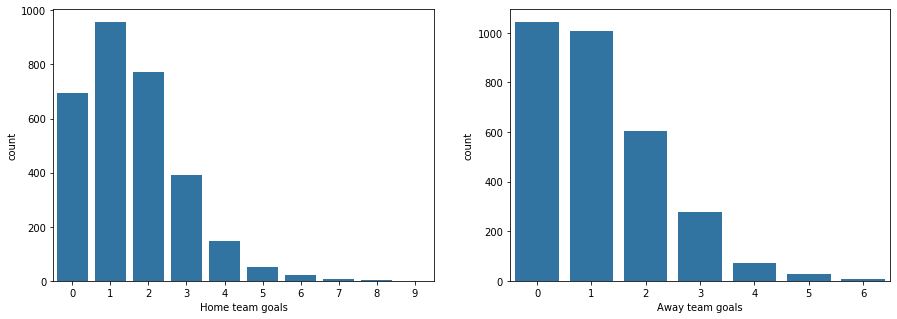

In [52]:
base_color = sb.color_palette()[0]
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
sb.countplot(data = PL_matches, x = 'home_team_goal', color = base_color);
plt.xlabel('Home team goals');
plt.subplot(1,2,2)
sb.countplot(data = PL_matches, x = 'away_team_goal', color = base_color);
plt.xlabel('Away team goals');

In [35]:
# Let's have a look at some of the outliers
PL_matches.query('home_team_goal > 6')

,id,season,stage,date,home_team_goal,away_team_goal,B365H,B365D,B365A,BWH,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,home_team,away_team
10,3369,2012/2013,20,2012-12-29 00:00:00,7,3,1.44,4.50,7.0,1.45,...,4.80,8.5,1.45,4.5,6.50,1.44,4.33,7.0,Arsenal,Newcastle United
399,2404,2009/2010,36,2010-04-25 00:00:00,7,0,1.14,8.00,21.0,1.12,...,8.50,19.0,1.15,7.0,15.00,1.12,7.50,23.0,Chelsea,Stoke City
543,2255,2009/2010,22,2010-01-16 00:00:00,7,2,1.22,6.00,15.0,1.20,...,6.00,15.0,1.22,6.0,11.00,1.22,5.50,13.0,Chelsea,Sunderland
636,4376,2014/2015,8,2014-10-18 00:00:00,8,0,1.57,4.00,7.0,1.62,...,4.00,6.5,NaN,NaN,NaN,NaN,NaN,NaN,Southampton,Sunderland
683,2421,2009/2010,38,2010-05-09 00:00:00,8,0,1.10,10.00,23.0,1.10,...,10.00,26.0,1.10,8.0,21.00,1.10,8.00,26.0,Chelsea,Wigan Athletic
707,2157,2009/2010,13,2009-11-22 00:00:00,9,1,1.44,4.33,8.0,1.45,...,4.33,7.5,1.45,4.0,7.25,1.44,4.00,8.0,Tottenham Hotspur,Wigan Athletic
1066,2549,2010/2011,15,2010-11-27 00:00:00,7,1,1.25,5.50,13.0,1.22,...,6.00,13.0,1.30,5.0,9.00,1.25,5.50,11.0,Manchester United,Blackburn Rovers
1071,3029,2011/2012,24,2012-02-04 00:00:00,7,1,1.29,5.50,11.0,1.28,...,6.00,13.0,1.25,5.5,11.00,1.29,5.00,10.0,Arsenal,Blackburn Rovers
1493,2366,2009/2010,32,2010-03-27 00:00:00,7,1,1.40,4.75,8.0,1.40,...,4.50,9.0,1.42,4.0,8.00,1.40,4.50,8.0,Chelsea,Aston Villa
1496,3339,2012/2013,18,2012-12-23 00:00:00,8,0,1.33,5.50,8.5,1.34,...,5.25,10.0,1.34,5.0,8.25,1.33,5.00,9.0,Chelsea,Aston Villa


Impressive stuff! I certainly remember the 8-2 Manchester United-Arsenal game.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

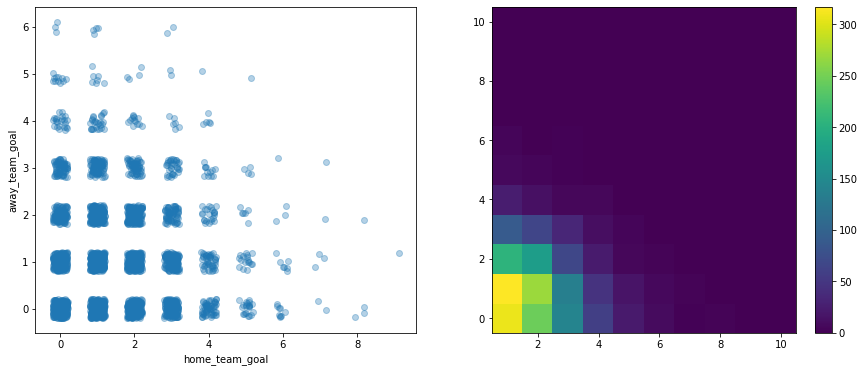

In [48]:
plt.figure(figsize = [15, 6])

# left plot: scatterplot of discrete data with jitter and transparency
plt.subplot(1, 2, 1)
sb.regplot(data = PL_matches, x = 'home_team_goal', y = 'away_team_goal', fit_reg = False,
           x_jitter = 0.2, y_jitter = 0.2, scatter_kws = {'alpha' : 1/3})

# right plot: heat map with bin edges between values
plt.subplot(1, 2, 2)
bins_x = np.arange(0.5, 10.5+1, 1)
bins_y = np.arange(-0.5, 10.5+1, 1)
plt.hist2d(data = PL_matches, x = 'home_team_goal', y = 'away_team_goal',
           bins = [bins_x, bins_y])
plt.colorbar();

In [ ]:
# univariate plots of cut, color, and clarity grades
season_order = PL_matches.season.unique()
season_order.sort()
season_class = pd.api.types.CategoricalDtype(ordered = True, categories = season_order)

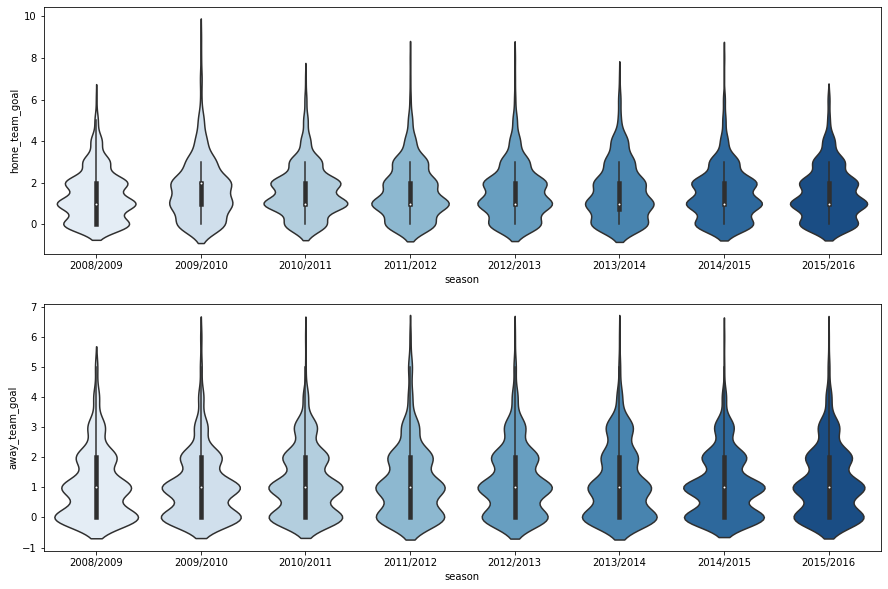

In [82]:
PL_matches['season'] = PL_matches['season'].astype(season_class)

plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
sb.violinplot(data = PL_matches, x = 'season', y = 'home_team_goal', palette = 'Blues');
plt.subplot(2,1,2)
sb.violinplot(data = PL_matches, x = 'season', y = 'away_team_goal', palette = 'Blues');

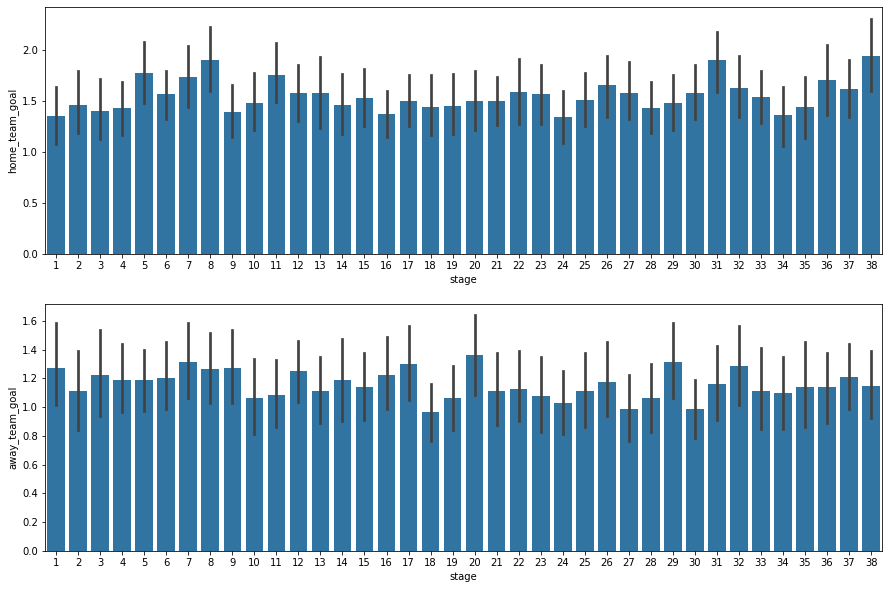

In [60]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
sb.barplot(data = PL_matches, x = 'stage', y = 'home_team_goal', color = base_color)
plt.subplot(2,1,2)
sb.barplot(data = PL_matches, x = 'stage', y = 'away_team_goal', color = base_color);

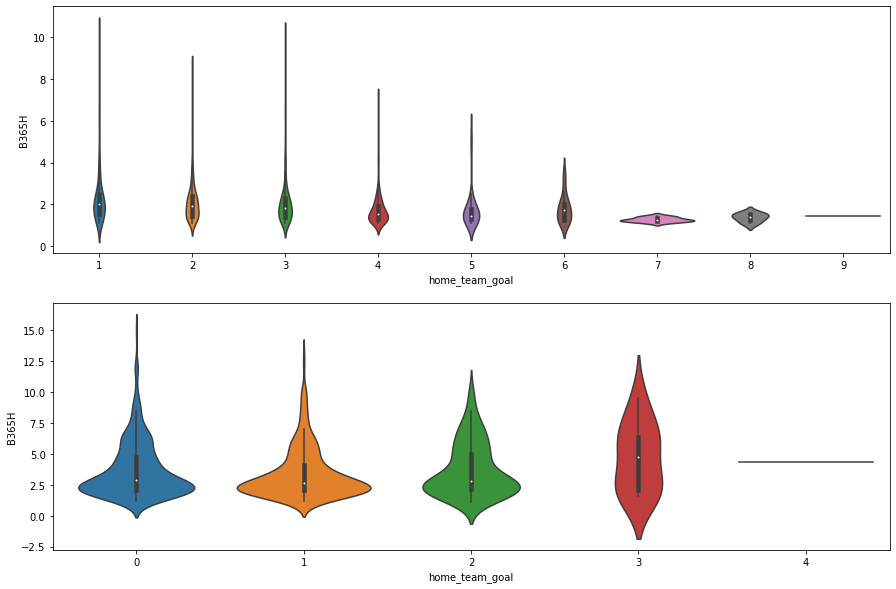

In [44]:
home_winners = PL_matches.query('home_team_goal > away_team_goal')
away_winners = PL_matches.query('home_team_goal < away_team_goal')
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
sb.violinplot(data = home_winners, x = 'home_team_goal', y = 'B365H')
plt.subplot(2,1,2)
sb.violinplot(data = away_winners, x = 'home_team_goal', y = 'B365H')

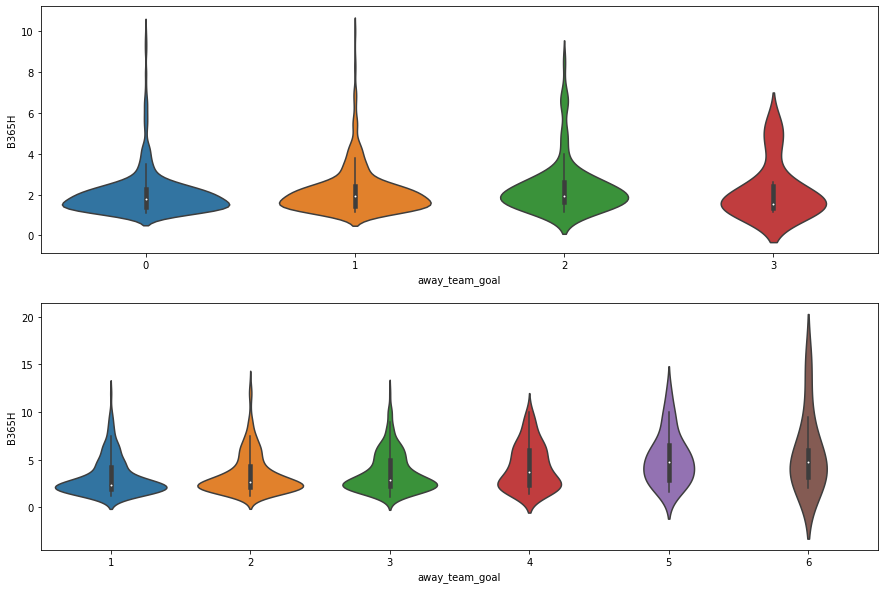

In [42]:
plt.figure(figsize = (15,10))
plt.subplot(2,1,1)
sb.violinplot(data = home_winners, x = 'away_team_goal', y = 'B365H')
plt.subplot(2,1,2)
sb.violinplot(data = away_winners, x = 'away_team_goal', y = 'B365H')

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!